In [1]:
# Optimization. Dimentionality Reduction by applying PCA

In [2]:
# %qtconsole

In [3]:
# imports
import matplotlib.pyplot as plt
import warnings
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from joblib import load
import seaborn as sns
import pandas as pd
import numpy as np
#
from moduleModelTraining import TrainingMethods
from moduleMetrics import MetricsMethods
from moduleUtilities import UtilityMethods
from moduleOptimization import OptimizationMethods
warnings.filterwarnings(action='ignore')

In [4]:
# class instances
train = TrainingMethods()
evaluate = MetricsMethods()
ut = UtilityMethods()
opt = OptimizationMethods()

In [5]:
# load data
x_part, y_part = None, None

# '','smote'
dataset_to_process = 'smote_'
# 'manual','auto'
features_to_process = 'auto'

x_part, y_part = None, None
with open('fragments/'+dataset_to_process+'x_'+features_to_process+'.joblib', 'rb') as f: x_part = load(f)
with open('fragments/'+dataset_to_process+'y_'+features_to_process+'.joblib', 'rb') as f: y_part = load(f)  

Best parameter (CV score=0.984):


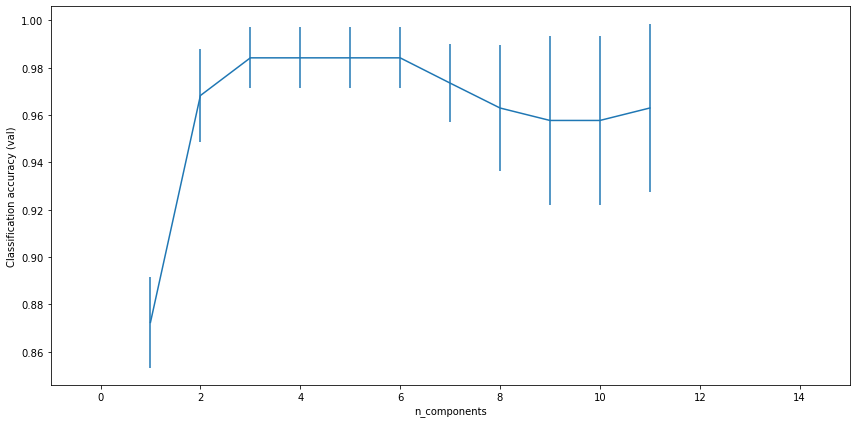

In [6]:
# find optimal number of PCs
opt.find_optimal_pcs_number(x_part, y_part)

pca_x: (188, 2)
Total explained variance of all PCs is:0.55%


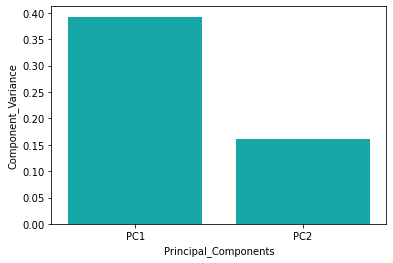

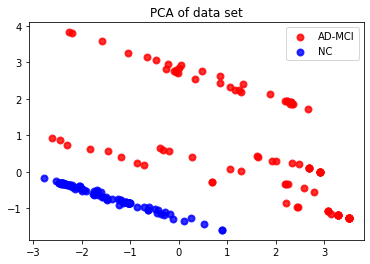

In [7]:
# Instantiate PCA transformer
pca_t = PCA(n_components=2)
pca_x = pca_t.fit(x_part).transform(x_part)
print('pca_x:',pca_x.shape)

# Just to remember that I do not fit or transform y (target_class). PCA is Unsupervised.
pca_y = y_part

# Save the PCA transformer
pkl.dump(pca_t, open('fragments/pca_t.joblib', 'wb')) # TODO create a separate folder to save transformers 

# Save data set with the extracted features (components)
pkl.dump(pca_x, open('fragments/'+dataset_to_process+'pca_x_'+features_to_process+'.joblib', 'wb'))
pkl.dump(pca_y, open('fragments/'+dataset_to_process+'pca_y_'+features_to_process+'.joblib', 'wb'))

total_pcs_variance = np.sum(pca_t.explained_variance_ratio_)
print(f'Total explained variance of all PCs is:{round(float(total_pcs_variance), 2)}%')

# Skee diagram
pc_df = pd.DataFrame(data=pca_x, columns=['PC1', 'PC2'])
pc_df['Cluster']=pca_y
pc_df.head()
df = pd.DataFrame({'Component_Variance': pca_t.explained_variance_ratio_, 'Principal_Components': ['PC1','PC2']})
sns.barplot(x='Principal_Components', y="Component_Variance", data=df, color="c");

# PCs, hue Target Class diagram AFTER PCA
plt.figure()
colors = ['red', 'blue']
lw = 2
for color, i, target_name in zip(colors, [1, 2], ['AD-MCI','NC']):
    plt.scatter(pca_x[pca_y == i, 0], pca_x[pca_y == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of data set')
plt.show();

In [8]:
# split of pca_x and smote_y to train test data set
pca_train_x, pca_test_x, pca_train_y, pca_test_y = train_test_split(pca_x, pca_y, random_state=ut.sd['random_state'],
                                                                    test_size=ut.sd['test_size'], stratify=pca_y)

Trained model:  lr  accuracy:  95.83
Trained model:  dt  accuracy:  93.61
Trained model:  rf  accuracy:  97.78
Trained model:  sv  accuracy:  95.83
Trained model:  gn  accuracy:  95.69
Trained model:  mp  accuracy:  95.83
Trained model:  kn  accuracy:  91.67
Trained model:  ce  accuracy:  97.92
Total training time: 1.58 seconds
Count of label NC (id 2 in Database, 1 in CM) in y_test: 24
Count of label AD-MCI (id 1 in Database, 0 in CM) in y_test: 23 



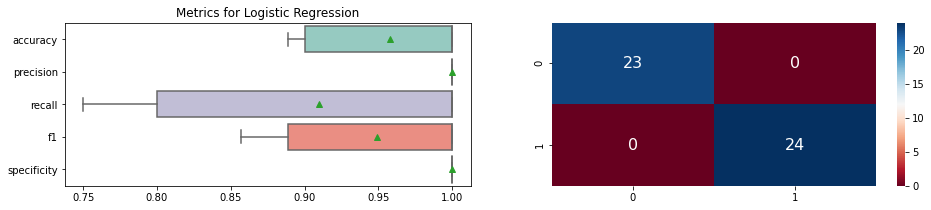

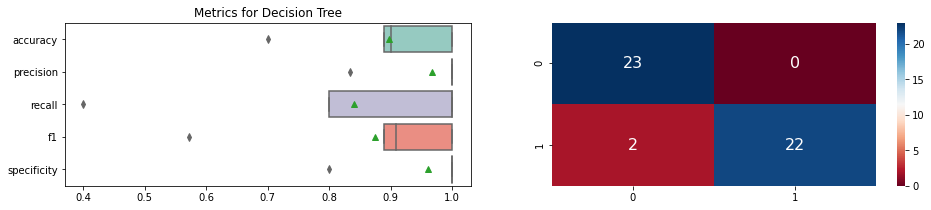

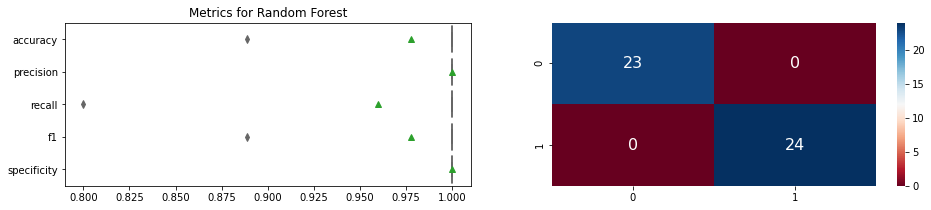

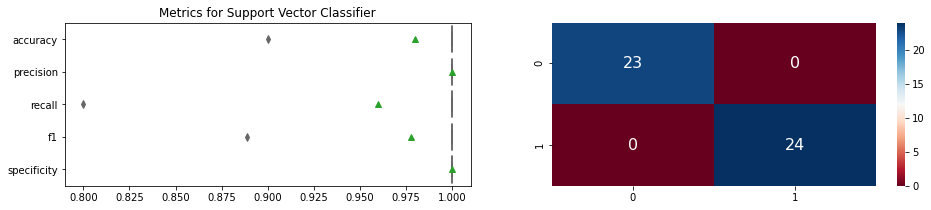

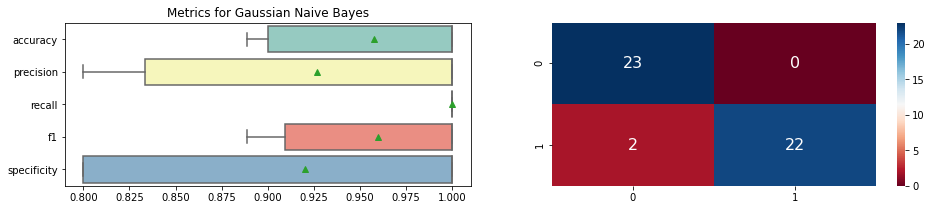

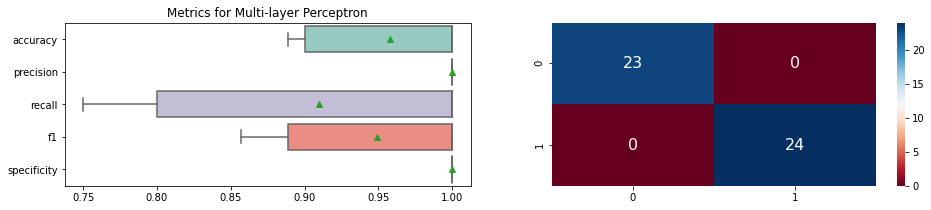

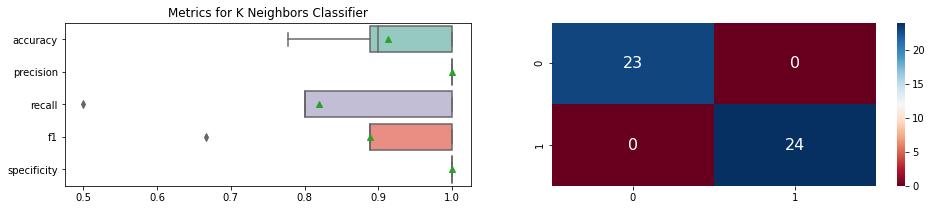

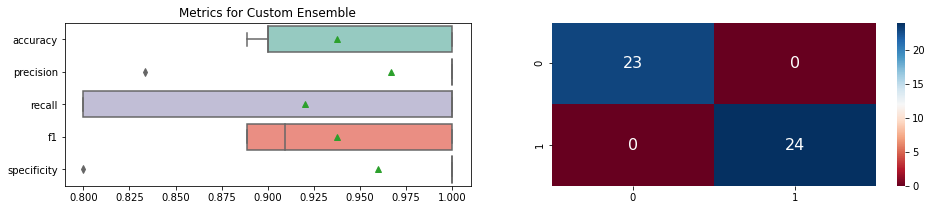

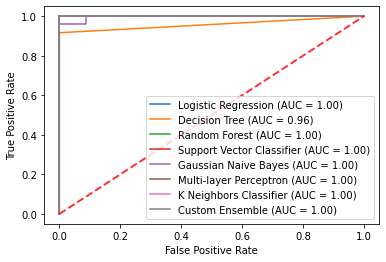

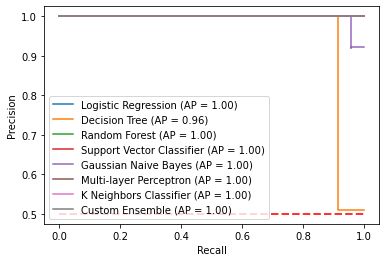

In [9]:
# train and evaluate models using the 2 components from PCA
trained_models_using_pca_comp = train.train_models(pca_train_x, pca_train_y, pca_test_x, pca_test_y)
evaluate.generate_metrics(trained_models_using_pca_comp, pca_test_x, pca_test_y, 
                          ['accuracy', 'precision', 'recall', 'f1', 'specificity'], 
                          cv_num=ut.sd['cv_num'], show_raw_data=False)

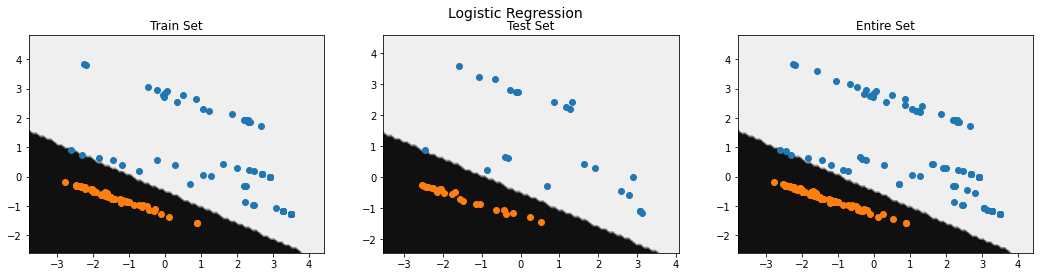

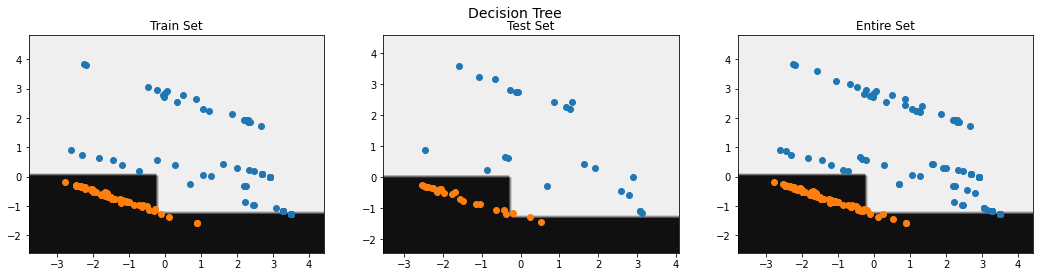

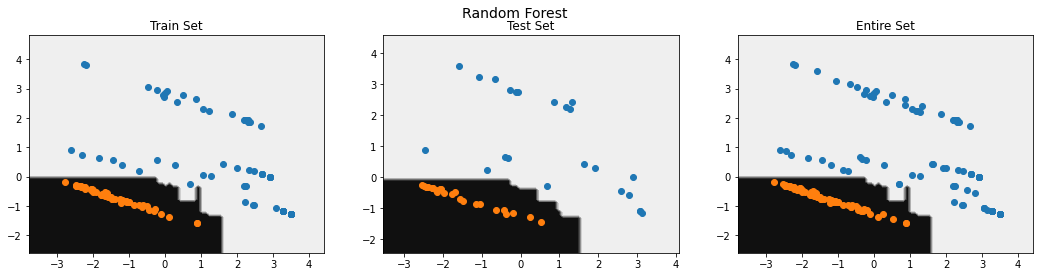

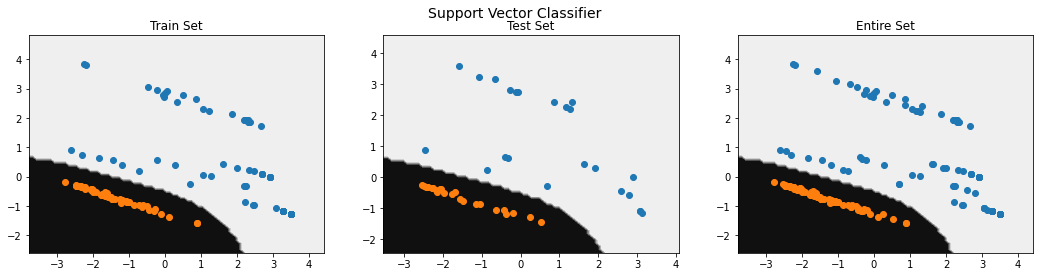

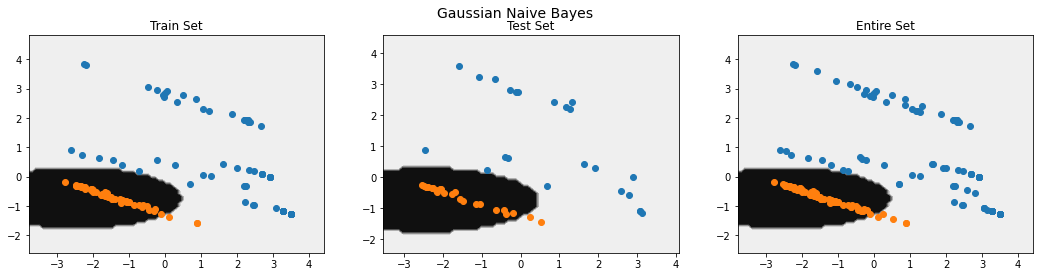

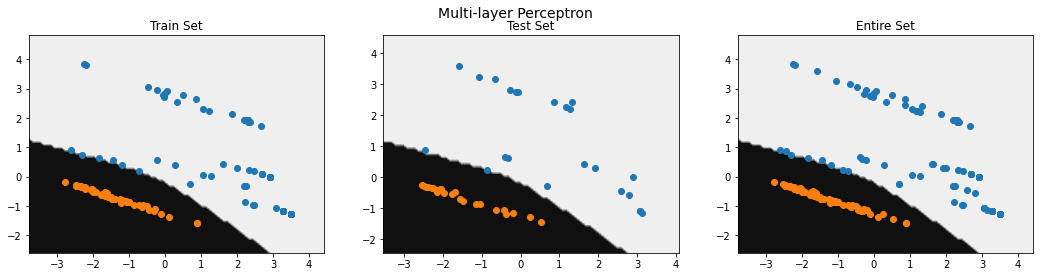

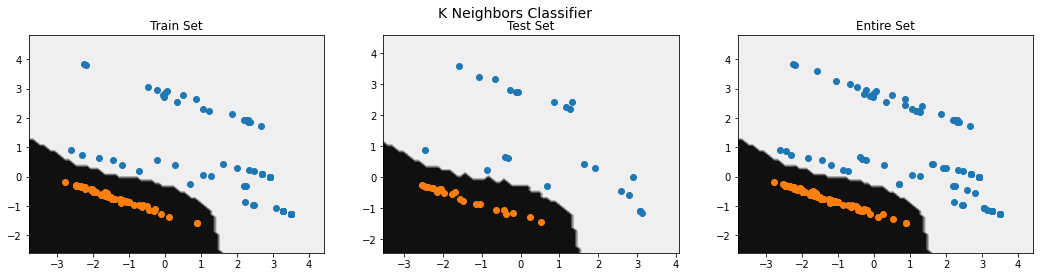

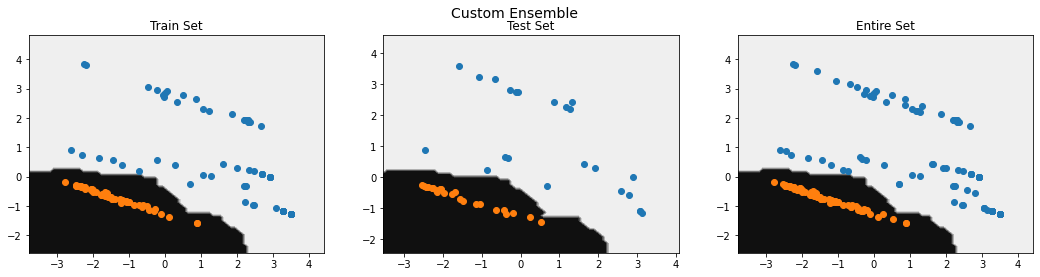

In [10]:
# Print decision surface for each Baseline model
data_set_tuples = [(pca_train_x, pca_train_y), (pca_test_x, pca_test_y), (pca_x, pca_y)]
show_probabilities = False
evaluate.print_decision_surface(trained_models_using_pca_comp, data_set_tuples, show_probabilities)